<a href="https://colab.research.google.com/github/qczhao92/ADAGE-on-L1000/blob/main/DDRi_rADAGE_Project_Model_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Discussion notebook: https://udemontreal-my.sharepoint.com/:o:/g/personal/qingchuan_zhao_umontreal_ca/EjBKZT4WPJ5Jkemsdlrw1LIBpz42h8cXQ-Jojda_NAv7xA?e=IdaRn6

In [ ]:
colab = True
# In case in Colab activate this cell by passing the corect path to the images
if colab==True: 
    from google.colab import drive
    drive.mount('/content/drive')
    work_dir = 'drive/MyDrive/AIforGenomics2021/ADAGE'
else:
    work_dir = ''

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys, os
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

In [ ]:
# set the path of files
l5data = "/content/drive/MyDrive/AIforGenomics2021/ADAGE/GSE70138_Broad_LINCS_Level5_COMPZ_n118050x12328_2017-03-06.gctx"
gene_info_txt = "/content/drive/MyDrive/AIforGenomics2021/ADAGE/GSE70138_Broad_LINCS_gene_info_2017-03-06.txt"
pert_info_txt = "/content/drive/MyDrive/AIforGenomics2021/ADAGE/GSE70138_Broad_LINCS_pert_info.txt"
sig_info_txt = "/content/drive/MyDrive/AIforGenomics2021/ADAGE/GSE70138_Broad_LINCS_sig_info_2017-03-06.txt"
cell_info_txt = "/content/drive/MyDrive/AIforGenomics2021/ADAGE/GSE70138_Broad_LINCS_cell_info_2017-04-28.txt"

# 0. Download L1000 data
download the 2 phase level 5 data to the working directory
https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE70138

In [ ]:
from tqdm import *
import os

if not os.path.exists(work_dir):
    os.system(f'mkdir -p {work_dir}')

if not os.path.isfile(gene_info_txt):
    gene_info_link ='ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE70nnn/GSE70138/suppl/GSE70138_Broad_LINCS_gene_info_2017-03-06.txt.gz'
    os.system(f'wget -O {gene_info_txt}.gz {gene_info_link}')
    os.system(f'gunzip {gene_info_txt}.gz')

if not os.path.isfile(pert_info_txt):
    pert_info_link ='ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE70nnn/GSE70138/suppl/GSE70138_Broad_LINCS_pert_info.txt.gz'
    os.system(f'wget -O {pert_info_txt}.gz {pert_info_link}')
    os.system(f'gunzip {pert_info_txt}.gz')

if not os.path.isfile(sig_info_txt):
    sig_info_link ='ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE70nnn/GSE70138/suppl/GSE70138_Broad_LINCS_sig_info_2017-03-06.txt.gz'
    os.system(f'wget -O {sig_info_txt}.gz {sig_info_link}')
    os.system(f'gunzip {sig_info_txt}.gz')

if not os.path.isfile(cell_info_txt):
    cell_info_link ='ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE70nnn/GSE70138/suppl/GSE70138_Broad_LINCS_cell_info_2017-04-28.txt.gz'
    os.system(f'wget -O {cell_info_txt}.gz {cell_info_link}')
    os.system(f'gunzip {cell_info_txt}.gz')

if not os.path.isfile(l5data):
    if not os.path.isfile(f'{l5data}.gz'):
        print('downloading L1000 level5 data... could take a while')
        l5data_link ='ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE70nnn/GSE70138/suppl/GSE70138_Broad_LINCS_Level5_COMPZ_n118050x12328_2017-03-06.gctx.gz'
        os.system(f'wget -O {l5data} {l5data_link}')
    else:
        print('Zipped L1000 level5 data exits!', f'starting unzip {l5data}.gz')
    os.system(f'gunzip {l5data}.gz')

In [ ]:
!ls /content/drive/MyDrive/AIforGenomics2021/ADAGE -all

total 6591142
-rw------- 1 root root  540934917 Dec 20  2018  9606.protein.links.v11.0.txt
-rw------- 1 root root  276119388 Mar 11 22:15  A549_full_gene_expression.csv
-rw------- 1 root root   21735820 Mar  8 19:16  A549_landmark_expression.csv
-rw------- 1 root root   33272309 Apr  8 18:02  DDRi_landmark_expression.csv
-rw------- 1 root root      11850 Mar  1 18:07  GSE70138_Broad_LINCS_cell_info_2017-04-28.txt
-rw------- 1 root root     621887 Mar  1 18:07  GSE70138_Broad_LINCS_gene_info_2017-03-06.txt
-rw------- 1 root root 5824120558 Mar  1 18:07  GSE70138_Broad_LINCS_Level5_COMPZ_n118050x12328_2017-03-06.gctx
-rw------- 1 root root     219965 Mar  1 18:07  GSE70138_Broad_LINCS_pert_info.txt
-rw------- 1 root root   18260895 Mar  1 18:07  GSE70138_Broad_LINCS_sig_info_2017-03-06.txt
-rw------- 1 root root      26513 Apr  8 19:46  landmark_gene_STRING_ID.txt
-rw------- 1 root root   31139750 Mar 22 18:38  PARPi_landmark_expression.csv
-rw------- 1 root root     392615 Mar 11 19:04 

## take a look of the information files

In [ ]:


gene_info = pd.read_csv(gene_info_txt, sep = '\t')
print(gene_info.shape)
gene_info.head()


(12328, 5)


,pr_gene_id,pr_gene_symbol,pr_gene_title,pr_is_lm,pr_is_bing
0,780,DDR1,discoidin domain receptor tyrosine kinase 1,1,1
1,7849,PAX8,paired box 8,1,1
2,2978,GUCA1A,guanylate cyclase activator 1A,0,0
3,2049,EPHB3,EPH receptor B3,0,1
4,2101,ESRRA,estrogen related receptor alpha,0,1


In [ ]:
pert_info = pd.read_csv(pert_info_txt, sep = '\t')
print(pert_info.shape)
pert_info.head()

(2170, 5)


,pert_id,canonical_smiles,inchi_key,pert_iname,pert_type
0,BRD-K70792160,CCN(CC)CCCCN1c2ccccc2Oc2ccc(Cl)cc12,GYBXAGDWMCJZJK-UHFFFAOYSA-N,10-DEBC,trt_cp
1,BRD-K68552125,CCCCCCCCCCCCCC(=O)O[C@@H]1[C@@H](C)[C@]2(O)[C@...,PHEDXBVPIONUQT-RGYGYFBISA-N,phorbol-myristate-acetate,trt_cp
2,BRD-K92301463,CCCCC(C)(C)[C@H](O)\C=C\[C@H]1[C@H](O)CC(=O)[C...,QAOBBBBDJSWHMU-WMBBNPMCSA-N,"16,16-dimethylprostaglandin-e2",trt_cp
3,BRD-A29731977,CCCCCC(=O)O[C@@]1(CCC2C3CCC4=CC(=O)CC[C@]4(C)C...,DOMWKUIIPQCAJU-JKPPDDDBSA-N,17-hydroxyprogesterone-caproate,trt_cp
4,BRD-K07954936,OC(=O)CCCC[C@@H]1SC[C@@H]2NC(=N)N[C@H]12,WWVANQJRLPIHNS-ZKWXMUAHSA-N,2-iminobiotin,trt_cp


In [ ]:
sig_info = pd.read_csv(sig_info_txt, sep = '\t')
print(sig_info.shape)
sig_info.head()

(118050, 8)


,sig_id,pert_id,pert_iname,pert_type,cell_id,pert_idose,pert_itime,distil_id
0,LJP005_A375_24H:A03,DMSO,DMSO,ctl_vehicle,A375,-666,24 h,LJP005_A375_24H_X1_B19:A03|LJP005_A375_24H_X2_...
1,LJP005_A375_24H:A04,DMSO,DMSO,ctl_vehicle,A375,-666,24 h,LJP005_A375_24H_X1_B19:A04|LJP005_A375_24H_X2_...
2,LJP005_A375_24H:A05,DMSO,DMSO,ctl_vehicle,A375,-666,24 h,LJP005_A375_24H_X1_B19:A05|LJP005_A375_24H_X2_...
3,LJP005_A375_24H:A06,DMSO,DMSO,ctl_vehicle,A375,-666,24 h,LJP005_A375_24H_X1_B19:A06|LJP005_A375_24H_X2_...
4,LJP005_A375_24H:A07,BRD-K76908866,CP-724714,trt_cp,A375,10.0 um,24 h,LJP005_A375_24H_X1_B19:A07|LJP005_A375_24H_X2_...


In [ ]:

sig_info[sig_info['pert_iname']=='e3330'].shape


(0, 8)

In [ ]:
#pick up DNA damage repair pathway inhibitor treated gene signatures
ola=sig_info[sig_info['pert_iname']=='olaparib'].astype(str)
ruca=sig_info[sig_info['pert_iname']=='rucaparib'].astype(str)
tala=sig_info[sig_info['pert_iname']=='talazoparib'].astype(str)
veli=sig_info[sig_info['pert_iname']=='veliparib'].astype(str)
ini=sig_info[sig_info['pert_iname']=='iniparib'].astype(str)
lome=sig_info[sig_info['pert_iname']=='lomeguatrib'].astype(str)
mito=sig_info[sig_info['pert_iname']=='mitoxantrone'].astype(str)
AZD7762=sig_info[sig_info['pert_iname']=='AZD-7762'].astype(str)
camp=sig_info[sig_info['pert_iname']=='camptothecin'].astype(str)
iri=sig_info[sig_info['pert_iname']=='irinotecan'].astype(str)

frames1=(ola, ruca, tala,veli, ini, mito, AZD7762, camp, iri, lome)
#PARPi=pd.concat(frames1)
DDRi=pd.concat(frames1)
DDRi.shape

(1630, 8)

In [ ]:
#pick up DMSO samples from the cell lines with PARPi treatment
DMSO=sig_info[sig_info['pert_iname']=='DMSO'].astype(str)
cell_lines=ola.cell_id.unique()
#DMSO_PARPi=DMSO[DMSO['cell_id'].isin(cell_lines)]
DMSO_DDRi=DMSO[DMSO['cell_id'].isin(cell_lines)]
DMSO_DDRi.head()


,sig_id,pert_id,pert_iname,pert_type,cell_id,pert_idose,pert_itime,distil_id
0,LJP005_A375_24H:A03,DMSO,DMSO,ctl_vehicle,A375,-666,24 h,LJP005_A375_24H_X1_B19:A03|LJP005_A375_24H_X2_...
1,LJP005_A375_24H:A04,DMSO,DMSO,ctl_vehicle,A375,-666,24 h,LJP005_A375_24H_X1_B19:A04|LJP005_A375_24H_X2_...
2,LJP005_A375_24H:A05,DMSO,DMSO,ctl_vehicle,A375,-666,24 h,LJP005_A375_24H_X1_B19:A05|LJP005_A375_24H_X2_...
3,LJP005_A375_24H:A06,DMSO,DMSO,ctl_vehicle,A375,-666,24 h,LJP005_A375_24H_X1_B19:A06|LJP005_A375_24H_X2_...
21,LJP005_A375_24H:B03,DMSO,DMSO,ctl_vehicle,A375,-666,24 h,LJP005_A375_24H_X1_B19:B03|LJP005_A375_24H_X2_...


In [ ]:
#randomly choose about 1500 DMSO samples
#DMSO_PARPi_R500=DMSO_PARPi.sample(n=500)
#DMSO_PARPi_R500.head()
DMSO_DDRi_R1500=DMSO_DDRi.sample(n=1500)
DMSO_DDRi_R1500.head()

,sig_id,pert_id,pert_iname,pert_type,cell_id,pert_idose,pert_itime,distil_id
73679,REP.A013_YAPC_24H:A05,DMSO,DMSO,ctl_vehicle,YAPC,-666,24 h,REP.A013_YAPC_24H_X1_B22:A05|REP.A013_YAPC_24H...
59784,REP.A008_MCF7_24H:F07,DMSO,DMSO,ctl_vehicle,MCF7,-666,24 h,REP.A008_MCF7_24H_X1_B24:F07|REP.A008_MCF7_24H...
107921,REP.A026_PC3_24H:F11,DMSO,DMSO,ctl_vehicle,PC3,-666,24 h,REP.A026_PC3_24H_X1_B25:F11|REP.A026_PC3_24H_X...
88674,REP.A019_HT29_24H:J18,DMSO,DMSO,ctl_vehicle,HT29,-666,24 h,REP.A019_HT29_24H_X1_B23:J18|REP.A019_HT29_24H...
66868,REP.A011_HELA_24H:A04,DMSO,DMSO,ctl_vehicle,HELA,-666,24 h,REP.A011_HELA_24H_X1_B24:A04|REP.A011_HELA_24H...


In [ ]:
#generate a new df with PARPi treated samples and 500 randome choosen DMSO samples
#frames2=(PARPi, DMSO_PARPi_R500)
#parpi_df=pd.concat(frames2)
#print(parpi_df.shape)
frames2=(DDRi, DMSO_DDRi_R1500)
ddri_df=pd.concat(frames2)
print(ddri_df.shape)
ddri_df.head()

(3130, 8)


,sig_id,pert_id,pert_iname,pert_type,cell_id,pert_idose,pert_itime,distil_id
24186,LJP008_A375_24H:D01,BRD-K02113016,olaparib,trt_cp,A375,10.0 um,24 h,LJP008_A375_24H_X1_B20:D01|LJP008_A375_24H_X2_...
24187,LJP008_A375_24H:D02,BRD-K02113016,olaparib,trt_cp,A375,3.33 um,24 h,LJP008_A375_24H_X1_B20:D02|LJP008_A375_24H_X2_...
24188,LJP008_A375_24H:D03,BRD-K02113016,olaparib,trt_cp,A375,1.11 um,24 h,LJP008_A375_24H_X1_B20:D03|LJP008_A375_24H_X2_...
24189,LJP008_A375_24H:D04,BRD-K02113016,olaparib,trt_cp,A375,0.37 um,24 h,LJP008_A375_24H_X1_B20:D04|LJP008_A375_24H_X2_...
24190,LJP008_A375_24H:D05,BRD-K02113016,olaparib,trt_cp,A375,0.12 um,24 h,LJP008_A375_24H_X1_B20:D05|LJP008_A375_24H_X2_...


## load L1000 level 5 data (gctx)


In [ ]:
landmark_gene_list = gene_info[gene_info['pr_is_lm'] == 1].astype(str)
print(landmark_gene_list.shape)
landmark_gene_list.head()

(978, 5)


,pr_gene_id,pr_gene_symbol,pr_gene_title,pr_is_lm,pr_is_bing
0,780,DDR1,discoidin domain receptor tyrosine kinase 1,1,1
1,7849,PAX8,paired box 8,1,1
25,6193,RPS5,ribosomal protein S5,1,1
43,23,ABCF1,ATP binding cassette subfamily F member 1,1,1
49,9552,SPAG7,sperm associated antigen 7,1,1


In [ ]:
!pip install cmapPy

     |████████████████████████████████| 153kB 8.4MB/s 


In [ ]:
## load the full gene expression data
from cmapPy.pandasGEXpress.parse import parse
#gene_expr_matrix_full = parse(l5data).data_df.T
# del gene_expr_matrix_full  ## release RAM

In [ ]:
## only load landmark genes
from cmapPy.pandasGEXpress.parse import parse

## Load the matrix of differential gene expressions as a pandas dataframe
gene_expr_matrix = parse(l5data, rid=landmark_gene_list["pr_gene_id"]).data_df.T


In [ ]:
#extract the PARPi_df landmark gene expression
#PARPi_gene_expr = gene_expr_matrix.loc[gene_expr_matrix.index.isin(parpi_df['sig_id'])]
#print(PARPi_gene_expr.shape)
#save PARPi_gene_expr
#PARPi_gene_expr.to_csv(f"{work_dir}/PARPi_landmark_expression.csv")

(940, 978)


In [ ]:
#extract the DDRi_df landmark gene expression
DDRi_gene_expr = gene_expr_matrix.loc[gene_expr_matrix.index.isin(ddri_df['sig_id'])]
print(DDRi_gene_expr.shape)
#save DDRi_gene_expr
DDRi_gene_expr.to_csv(f"{work_dir}/DDRi_landmark_expression.csv")

(3130, 978)


# 1. ADAGE model









construct an ADAGE-based model:
1. adding random noise to the input data
2. training a neural network with hidden nodes that were able to remove added noise to reconstruct the initial data

In [ ]:
from IPython.display import Image
Image(work_dir+'/img/ADAGEmodel.png', width="800")

### 1.1 define the model

for each sample $x$:
- random corrupt a percentage of the genes -> 0
- use corrupt sample $x'$ as input of denoising autoencoder

for each encoder node, calculate activity with weight matrix W:
> $Y = s(Wx'+b)$

the reconstructed gene expression by decoder node:
> $z =  W'y + b' $

use Mean Squared Error as loss function
> $L(x,z) = \frac{1}{n}\sum_{k=1}^n (x_k  -z_k)^2$


In [ ]:

class Adage_linear_decoder(nn.Module):
    """Denoising Auto-Encoder: to reconstruct the input from a corrupted gene expression"""
    
    def __init__(self, gene_number, node_number = 50, encoder_layers = 1):
        super(Adage_linear_decoder, self).__init__()

        hidden_layers = []
        current_node=gene_number
        if encoder_layers > 1:
            delta = (gene_number - node_number) / encoder_layers
            current_node = gene_number
            for i in range(encoder_layers-1):
                n = int(current_node - delta)
                hidden_layers.append(nn.Linear(current_node, n))
                hidden_layers.append(nn.ReLU(inplace=True))
                current_node = n

        self.encoder = nn.Sequential(
            *hidden_layers,
            nn.Linear(current_node, node_number),
            nn.ReLU(inplace=True)         
        )
        self.decoder = nn.Linear(node_number, gene_number)
        
    def forward(self,x):
        y = self.encoder(x)
        y = self.decoder(y)
        return y

Some functions for training:

In [ ]:
# define an random corruption function
def random_corruption(train_batch, corruption_rate = 0.05):
    """ Take a pandas dataframe as input. In each sample (as rows), random corrupt a proportion (corruption_rate) of the genes to 0. """
    nrow, ncol = input_dataframe.shape
    corrupt_mask = numpy.random.choice([0, 1], size=ncol, p=[corruption_rate, 1-corruption_rate])

    for i in range(1, nrow):
        corrupt_array = numpy.random.choice([0, 1], size=ncol, p=[corruption_rate, 1-corruption_rate])
        corrupt_mask = np.vstack(corrupt_mask, corrupt_array)
    
    return input_dataframe.dot(corrupt_mask)

In [ ]:
# define an random noise introducer function
def random_noise(train_batch, random_rate = 0.05, std=0.1):
  noise=np.random.normal(0,std,train_batch.shape)
  rate=np.random.choice([0, 1], size=train_batch.shape, p=[1-random_rate, random_rate])
  new_signal=train_batch+noise*rate
  return new_signal
    

In [ ]:
## function to split the training and validation data
def train_valid_split(dataframe, train_portion = 0.7):
    """take a pandas dataframe as input, output two numpy arrays according to train_portion"""
    data = dataframe.to_numpy()
    np.random.shuffle(data)
    train_data, valid_data = data[:int(data.shape[0]*train_portion),:], data[int(data.shape[0]*train_portion):,:]

    print('samples in training data:',train_data.shape[0],'\nsamples in validation data:',valid_data.shape[0])
    return train_data, valid_data
 
## function to prepare input data
def dataloader(data, batch_size, reuse = True):
    """ prepare a batch of datasets for ADAGE model input """
    np.random.shuffle(data)
    num_batches = len(data) // batch_size
    while True:
        for i in range(num_batches):
            yield data[i * batch_size : (i + 1) * batch_size]
        if not reuse and i == num_batches - 1:
            yield None

## function to save model
def save_models(work_dir, model, epoch_number,model_name):
    """Function to save trained model"""
    save_dir = os.path.join(work_dir, "trained_model")
    os.makedirs(save_dir, exist_ok=True)
    torch.save(model.state_dict(), '{}/{}_epoch{}'.format(save_dir, model_name, epoch_number))


### 1.2 train the model

load the data for training and validation

In [ ]:
#PARPi_gene_expr = pd.read_csv(f"{work_dir}/PARPi_landmark_expression.csv", index_col=0)

#print(f'data range from {PARPi_gene_expr.values.min()} to {PARPi_gene_expr.values.max()}')
#PARPi_gene_expr.head()

data range from -10.000001 to 10.000001


,780,7849,6193,23,9552,387,10921,10285,533,6194,23326,351,1213,9761,1465,808,5792,3337,7494,2896,3098,11014,6500,823,813,1509,4144,3925,1891,8826,3303,3329,1153,5720,5048,10525,5708,2058,5710,5223,...,11182,63933,54850,29916,55179,29083,7099,79961,55825,51742,10818,81533,665,10776,64422,10813,80349,1978,83743,57406,23410,8996,55620,23597,124583,54915,3157,85377,55793,466,54681,11000,6915,6253,7264,5467,2767,23038,57048,79716
cid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
REP.A001_A375_24H:J15,0.547654,0.395950,0.461493,-0.321076,0.171693,0.679893,-0.116500,-0.142482,-0.018586,0.000000,-0.259256,-0.266754,0.013334,0.615622,0.342822,-0.015804,0.379034,-0.082581,-0.490875,0.529229,1.097920,0.083174,0.223464,0.822543,-0.646200,0.105072,0.386202,0.611098,-0.215986,-0.233854,-0.489597,-0.674382,0.746366,0.424303,-0.134211,0.217497,-1.080208,0.647623,0.420543,-4.904697,...,-0.091081,0.325788,-0.106197,0.603988,0.292633,-0.251299,-0.411023,0.837104,-0.876019,0.427095,-0.398287,-0.047654,0.112173,0.414505,-3.028268,0.472928,0.539418,-0.339128,-0.505857,-0.134691,-1.025917,-0.073245,-0.022658,-5.064618,0.100468,0.423215,0.119007,0.955357,-0.564962,-0.446641,-0.124934,0.664942,0.527476,0.352047,-0.052228,-0.784120,-0.967061,-0.393171,0.398492,-0.336368
REP.A001_A375_24H:J16,-0.011768,-1.067306,-0.113229,0.402519,-0.256621,-0.536988,0.471351,-0.789072,0.221237,0.000000,0.597305,0.131708,0.697712,0.274119,-0.225368,0.523252,0.356316,-0.231118,-1.101972,1.162249,0.326193,-0.326843,0.248999,0.237429,-1.456901,-0.219513,0.771570,0.128634,0.646212,-0.020452,-3.920552,-0.772525,2.329190,-0.489395,-0.108981,0.183556,0.053364,-0.193271,0.233431,0.556484,...,-0.326120,-0.207436,-0.190311,-0.273263,-0.475273,-0.218992,-0.173596,-0.067220,-0.734452,1.009016,-1.384133,-0.524755,-0.227863,0.474416,-0.320282,-0.850814,1.125106,-0.108594,-0.597689,0.287199,-0.506501,-0.469675,-1.182983,-0.073488,0.429464,1.339783,0.272432,-0.030471,0.859062,-0.638941,0.079704,-0.052292,0.420883,0.174849,0.901950,-0.674315,-0.665947,0.821813,0.212107,-0.332485
REP.A001_HA1E_24H:A03,-0.612091,0.855054,-0.557836,-0.036146,-0.533345,0.430169,0.282822,0.654875,-0.239361,0.768740,0.392429,-0.381888,0.759375,-0.328399,0.399033,-0.758860,0.309794,0.802563,0.908873,-0.506241,0.042305,0.278327,-0.636894,-0.522274,0.305060,-0.587657,0.357382,0.270920,0.212523,-0.301421,-0.553881,0.440242,-0.092588,0.224921,0.794614,0.587701,0.790196,0.767115,0.097447,0.852140,...,0.575854,0.416091,0.335926,-0.105096,-1.305800,0.154202,-0.662583,-0.379384,-1.224841,0.785541,-0.255037,-0.050673,-0.406081,0.352848,0.547996,1.790532,0.505057,-0.638764,-0.674412,-0.240601,-0.084365,-0.153685,0.451601,0.005528,0.715036,0.149368,1.115302,0.216178,4.816076,-0.433131,0.153344,1.064444,-0.119862,0.250326,-0.233840,-0.070832,0.092717,-0.193244,-0.297614,1.408907
REP.A001_HA1E_24H:F08,-0.295567,0.264896,0.225759,0.416773,0.554485,0.319323,0.632860,0.218394,0.062931,-1.405682,-0.888978,-0.092187,-0.783735,0.982590,0.630364,0.062697,-0.597367,-0.245464,0.436860,0.747253,0.158223,-0.070773,0.817261,0.522098,-0.046936,0.105714,0.296335,0.354037,-0.358646,-0.606546,-0.873109,0.355777,1.321212,0.378128,0.302558,-0.103678,1.104395,0.535756,0.772063,0.209416,...,-0.569899,0.037671,-0.080219,0.677563,0.377883,0.585444,-0.471824,0.461182,0.325555,-0.321512,-0.341110,-1.335096,0.882909,0.597172,0.188407,-0.172315,0.318651,0.045284,0.087886,-0.644419,4.048363,0.274434,-0.137777,0.280535,0.772253,0.349798,-0.569966,-0.644179,2.285106,0.370050,1.895253,-0.882176,-0.299036,-0.871814,0.408248,0.401330,-0.482904,3.989376,0.614656,-0.309702
REP.A001_HA1E_24H:J14,-0.844051,0.076854,0.458108,-0.285793,-0.434120,0.084801,0.670759,0.649724,0.291303,0.319341,-1.645912,-0.476368,1.074345,1.229127,0.949046,-0.447085,-0.387231,0.096495,-0.031915,0.389765,0.951611,0.625000,1.182070,1.178186,1.350742,-0.595371,-0.105703,-0.129478,-0.705864,-0.629163,-1.338078,0.705596,0.815922,0.940423,-0.513836,0.0

In [ ]:
DDRi_gene_expr = pd.read_csv(f"{work_dir}/DDRi_landmark_expression.csv", index_col=0)

print(f'data range from {DDRi_gene_expr.values.min()} to {DDRi_gene_expr.values.max()}')
DDRi_gene_expr.head()

data range from -10.000001 to 10.000001


,780,7849,6193,23,9552,387,10921,10285,533,6194,23326,351,1213,9761,1465,808,5792,3337,7494,2896,3098,11014,6500,823,813,1509,4144,3925,1891,8826,3303,3329,1153,5720,5048,10525,5708,2058,5710,5223,...,11182,63933,54850,29916,55179,29083,7099,79961,55825,51742,10818,81533,665,10776,64422,10813,80349,1978,83743,57406,23410,8996,55620,23597,124583,54915,3157,85377,55793,466,54681,11000,6915,6253,7264,5467,2767,23038,57048,79716
cid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
REP.A001_A375_24H:A03,4.264143,0.057249,-2.139334,-0.221784,-0.376555,1.913788,0.065576,-0.868953,-0.102273,0.0,0.525076,0.494065,-0.179588,-0.617669,-0.058411,0.247190,-0.432858,-0.321727,-1.285001,-0.388950,-0.088958,-0.097954,0.685952,0.959470,0.559862,-2.502630,0.359842,0.217574,-0.128369,-0.481144,2.042193,0.135226,0.144666,0.387548,0.729601,-0.751490,0.224599,0.833347,-0.174646,-0.300092,...,1.161566,0.096894,-0.609974,0.984338,1.298751,-0.444139,-0.077251,-0.863196,-2.093450,0.892946,-0.151042,0.596993,-0.246462,0.478527,0.458574,-0.213532,1.343217,-0.918547,-0.231647,-0.885711,4.704529,-2.583687,-0.847691,-0.324260,0.621623,-0.122100,-0.189515,0.455307,-0.686222,0.886410,5.246200,0.057058,-1.256173,-0.025255,0.168856,-1.639110,0.685100,-0.419421,1.716090,-0.472335
REP.A001_A375_24H:A05,-0.571711,-0.754999,-0.710110,0.428894,0.272606,0.314359,-1.545846,0.641955,-0.876852,0.0,0.690696,0.259465,0.097236,0.346196,-3.480344,1.192023,-0.129932,-0.620908,-0.145761,-0.332579,-0.397863,-0.064081,-0.068735,-0.371589,0.399846,-0.188653,0.410684,0.174939,0.144009,-0.855949,0.419143,0.437832,-0.056314,-0.193758,0.309855,-0.107573,-0.274771,0.739789,0.168686,-0.276458,...,0.951568,0.153254,0.333606,-1.179648,-0.143009,-3.184037,0.056141,-0.642681,-0.075741,0.566838,-0.080453,0.465662,-1.577573,0.348894,0.720928,0.386417,-0.043855,-0.482106,-0.964702,-0.561778,3.391710,-0.009394,0.393942,-0.046790,0.572470,1.012875,-0.393289,0.280188,0.407029,-0.021540,-0.005612,1.194516,0.171107,0.334370,-1.089265,-0.114638,0.304832,-0.249467,-0.428352,1.584976
REP.A001_A375_24H:B06,0.090035,-0.126354,-0.677804,0.018699,-0.171359,-0.929230,-0.518167,0.909588,-0.629458,0.0,-0.634575,-0.890770,0.184573,-0.052825,0.424141,0.070593,0.385842,-0.593042,0.129773,-0.033163,0.311473,-0.330706,0.164594,-0.221457,-0.005973,-0.995336,0.120785,0.053835,0.398550,-0.883482,0.685645,-0.013409,0.732580,-0.587955,0.539009,-0.578586,1.014374,0.081978,0.507190,-0.581820,...,0.413326,1.103752,0.282647,0.147169,0.148795,-0.378066,-0.546149,-0.626941,-0.330729,-0.066034,0.085613,-0.283772,-0.040362,0.326949,0.807251,-0.090438,-0.043841,-0.120055,-0.403158,-0.087850,-0.310649,-0.350287,-0.580429,-0.122886,0.505836,-0.156736,-0.225532,-0.142011,4.102704,-0.957159,0.084765,4.083964,0.736748,-0.130357,0.229097,0.445147,0.391595,0.203354,-0.038053,1.808435
REP.A001_A375_24H:F08,0.486323,-0.048152,-0.026651,-0.189330,0.746427,0.543150,-0.041739,-0.155129,-0.080053,0.0,-0.231303,-0.350301,-0.478873,-0.303196,-1.122758,-0.690514,-0.402801,-0.385334,-0.081466,0.572392,0.531504,-0.543804,0.836444,0.302225,0.624687,0.161752,0.196965,-0.036358,-0.683191,-0.037815,-3.346440,0.127267,-0.331009,0.524529,-0.330875,-0.063817,-0.292505,0.148976,0.989419,0.475239,...,0.278010,0.889349,0.194808,0.356561,-0.019010,-0.062983,0.317133,0.100935,0.297193,0.496246,0.427417,-0.396475,0.593992,-2.287117,0.214099,-0.154662,0.111357,-0.589143,-0.318355,0.214677,-0.138251,0.085525,-0.622205,-1.362202,-0.138776,1.148892,0.809686,-0.360932,0.367233,-0.328657,0.051168,-0.141523,0.750948,-0.458847,-0.501552,0.674004,-0.091482,0.245796,0.853410,-0.368149
REP.A001_A375_24H:F11,0.782842,0.023534,0.295156,-0.415375,1.151106,0.086564,0.271207,-0.450202,0.494099,0.0,0.069646,-0.189121,0.259846,0.307957,0.206965,0.182580,-1.241487,0.166138,0.047024,0.351032,0.186668,0.499309,0.678594,-0.656629,-0.135447,-1.372328,-0.038117,0.261096,-0.367883,0.803902,-0.768213,0.639764,-0.389107,1.236705,0.028638,4.135058,-0.

In [ ]:
DDRi_gene_expr_rn=random_noise(DDRi_gene_expr)
DDRi_gene_expr_rn.head()

,780,7849,6193,23,9552,387,10921,10285,533,6194,23326,351,1213,9761,1465,808,5792,3337,7494,2896,3098,11014,6500,823,813,1509,4144,3925,1891,8826,3303,3329,1153,5720,5048,10525,5708,2058,5710,5223,...,11182,63933,54850,29916,55179,29083,7099,79961,55825,51742,10818,81533,665,10776,64422,10813,80349,1978,83743,57406,23410,8996,55620,23597,124583,54915,3157,85377,55793,466,54681,11000,6915,6253,7264,5467,2767,23038,57048,79716
cid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
REP.A001_A375_24H:A03,0.346951,-0.072225,0.263486,-0.911088,0.034348,0.133839,-0.465517,0.699463,0.179825,0.000000,-0.397597,-0.935994,-0.020811,-1.028512,-2.519510,0.254389,-0.121619,1.249585,0.117861,-0.831263,-0.771881,-1.938656,-0.007787,-0.585267,0.232465,-0.456491,0.447082,0.337116,-0.180163,-0.973887,-0.019860,0.731367,-0.036499,0.566481,-0.667920,0.513303,-0.074567,-0.942845,0.096436,-0.087692,...,0.164731,1.824395,-0.001707,2.955862,0.305478,0.209582,1.848617,1.012357,0.696036,-0.684889,-0.582877,-1.399600,-0.889834,-1.178846,0.279318,1.119270,0.407685,1.299560,-2.740435,-0.693942,0.892831,0.026476,-0.085264,0.417326,-0.639990,0.215025,-0.199806,-0.572732,0.147290,0.025148,0.203578,0.950807,3.208275,1.185582,0.460981,-1.106293,0.601467,0.757136,0.427717,-1.037486
REP.A001_A375_24H:A05,0.583586,-1.313570,-0.054442,-2.159236,-0.344172,1.239863,-0.336611,-0.919846,0.898237,0.001418,0.674341,0.000241,1.134536,0.930300,-0.306106,-2.298258,-2.097048,0.406541,0.259399,-0.114275,0.733237,0.975634,0.335389,0.499952,0.256970,-1.428313,1.880708,1.566421,-1.225143,-2.058756,-0.678872,-0.331356,0.468274,0.260269,0.187290,-1.597586,-1.005662,0.471443,0.460908,-0.443206,...,0.882257,1.213797,2.098609,1.041858,-1.285834,-0.584476,-0.707017,0.173405,-1.090760,2.229658,-0.019146,-0.681150,1.138265,1.025823,-0.144150,-1.000786,0.623558,0.022526,0.956489,-0.792409,3.127322,-1.181600,-1.138221,-0.350499,0.295302,0.165968,0.000991,4.224746,-0.318300,1.370810,0.407046,-0.924363,-1.165396,-0.933684,0.191026,-0.790862,0.696797,1.429895,1.126931,-0.826261
REP.A001_A375_24H:B06,-0.239851,-0.513102,-0.777243,-0.314719,-0.589689,0.644182,0.190117,-0.473368,-0.155920,0.484108,1.252349,-0.757016,0.284382,-0.903291,0.152020,-0.132840,-1.049063,0.261602,0.122313,0.201640,0.503672,0.546444,0.202881,0.129837,0.378768,0.674284,0.281716,0.242391,-0.462490,0.147127,0.367566,0.728866,0.904291,0.170927,-0.275767,0.045164,0.345351,-0.182215,0.398809,0.458738,...,-0.235727,1.571898,-0.781109,1.323763,-0.319975,-0.346691,3.509586,0.263932,2.286774,-0.156389,-0.010751,-1.691814,-0.560015,0.506985,0.753619,-3.069787,0.164010,0.554008,0.759607,-0.393747,2.755333,0.559180,0.133438,-0.678692,0.395368,0.575078,-0.044171,0.488836,0.427758,0.236872,0.207849,-0.343398,-0.633409,-1.247897,-0.711078,-0.215181,0.225914,0.026922,-1.650863,0.638502
REP.A001_A375_24H:F08,-0.766225,-1.275173,0.679984,-0.253703,-1.927102,0.515917,1.585518,1.094815,0.499072,0.028714,0.427401,-0.981079,0.477132,-0.045834,0.836801,-0.210036,-0.690459,0.250163,0.137765,-0.597090,0.006441,0.649895,0.823322,-0.245850,-0.145002,-0.847882,0.644175,-0.069473,-1.531104,0.002089,0.020892,0.674786,-0.824802,-0.386345,-0.734920,-1.200396,-0.591726,-0.842944,0.349293,0.242944,...,-1.122287,0.128276,-0.140897,0.774912,-0.790092,0.992719,0.459722,-0.815332,-0.532001,-0.222669,0.093182,-0.893619,0.565390,0.352403,-1.029945,0.534839,1.441194,0.545300,0.932863,-0.880891,-0.206184,-0.912651,-0.653018,1.017586,-2.933846,0.840421,0.054654,0.357397,-0.531720,0.998522,-0.822373,-1.183868,1.491937,-1.063638,0.629134,0.367977,-0.542443,-0.246186,0.400520,-0.930262
REP.A001_A375_24H:F11,0.006897,-0.180128,-0.389726,0.550577,-0.759457,-0.279520,0.317637,0.560946,-0.264962,0.270989,-0.518505,-0.025443,0.165745,0.278006,-0.224238,-0.255243,-0.280360,0.107095,0.639675,0.165720,-0.013417,0.007822,0.261039,-0.991556,0.495247,0.435768,0.123973,0.076726,-0.276655,0.065011,-0.835046,-0.296712,0.137708,0.548029,-0.666521,-0.1

In [ ]:
# define the dataframe to be used
dataf = DDRi_gene_expr_rn
# split datasets
train_data, valid_data = train_valid_split(dataf)
# initiate dataloader
train_loader = dataloader(train_data, 80)
valid_loader = dataloader(valid_data,80)

samples in training data: 2191 
samples in validation data: 939


Visualization of the model structure

In [ ]:
!pip install torchviz

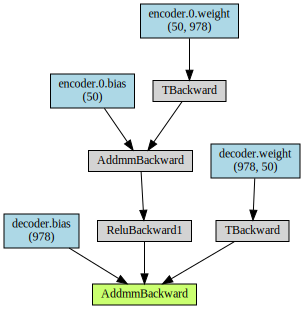

In [ ]:
# visualize the structure of the model
from torchviz import make_dot, make_dot_from_trace
x = next(train_loader)
x = torch.tensor(x).float()
make_dot(DA(x), params=dict(list(DA.named_parameters())))

Now, we start training

In [ ]:
## training function
def train_model(model, model_name , valid_point_epoch = 30 , model_save_epoch = 200 , iteration_n = 15000, print_train = True):
    
    criterion = nn.MSELoss()
    optimizer=optim.Adam(list(model.parameters()), lr=learning_rate, weight_decay=0.0002)

    start_time = time.time()
    print('training start at %s '%(time.ctime(start_time)),'_'*50)
    train_loss_record = []
    valid_loss_record = []

    for epoch in range(iteration_n): 
        inputs = next(train_loader)
        if noise:
            inputs_n = random_noise(inputs)
        else:
            inputs_n = inputs

        inputs = torch.tensor(inputs).float()
        inputs_n = torch.tensor(inputs_n).float()

        # zero the parameter gradients
        optimizer.zero_grad()
        loss = criterion(model(inputs), inputs)
        loss.backward()
        optimizer.step()  # Update the parameters of the model

        # print statistics
        batch_loss = np.mean(loss.item())
        #epochs.append(epoch+1)
        #train_loss.append(batch_loss) 
        train_loss_record.append((epoch+1, batch_loss))

        if print_train and epoch % 50 == 49:    # print every 50 epochs
            print('epoch %d loss: %.3f' %
                  (epoch + 1, np.mean(loss.item())))
        if epoch % valid_point_epoch == valid_point_epoch-1:
            valid_inputs = next(valid_loader)
            valid_inputs = torch.tensor(valid_inputs).float()
            valid_loss = criterion(model(valid_inputs), valid_inputs)
            valid_loss_record.append((epoch+1, np.mean(valid_loss.item())))

        # save check point models
        if epoch % model_save_epoch == model_save_epoch-1:
            save_models(work_dir,model,train_loss_record[-1][0],model_name)
    print('_'*50,'\nFinished Training at', time.ctime(time.time()), '\ntotal training time: %.2f s' %(time.time()-start_time))

    with open(f'{work_dir}/trained_model/{model_name}_train_loss_record.txt','w+') as ft:
        ft.write('\n'.join('%s\t%s' % x for x in train_loss_record))
    with open(f'{work_dir}/trained_model/{model_name}_valid_loss_record.txt','w+') as fv:
        fv.write('\n'.join('%s\t%s' % x for x in valid_loss_record))
    
    %matplotlib inline
    ## plot the training and validation curve
    plt.close()
    plt.plot(*zip(*train_loss_record),color='orange')
    plt.plot(*zip(*valid_loss_record),color='green')
    plt.xlabel("epoch")
    plt.ylabel("MSE")
    plt.savefig(f'{work_dir}/trained_model/{model_name}.pdf')
    
    return model

ADAGE Network Architecture:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Adage_linear_decoder(
  (encoder): Sequential(
    (0): Linear(in_features=978, out_features=50, bias=True)
    (1): ReLU(inplace=True)
  )
  (decoder): Linear(in_features=50, out_features=978, bias=True)
)

training start at Tue Apr 13 20:20:16 2021  __________________________________________________
__________________________________________________ 
Finished Training at Tue Apr 13 20:20:33 2021 
total training time: 16.96 s
r_squre: 0.43279416700800943


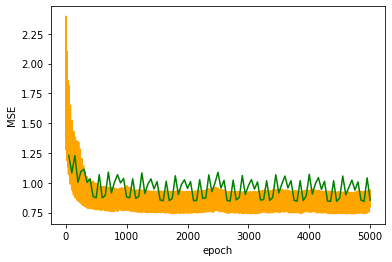

In [ ]:
## set hyper-parameters
node_n=50
layers = 1

learning_rate = 0.002
iteration_n = 5000

model_name=f"{layers}layers_{node_n}nodes_landmarkgene_DDRi_r"
valid_point_epoch = 50
model_save_epoch = 500

## instantiate the model
DA = Adage_linear_decoder(train_data.shape[1], node_number=node_n, encoder_layers = layers)
print("{}\nADAGE Network Architecture:\n{}\n{}\n".format("="*31, "~"*31, DA))

## train the model
DA = train_model(DA, model_name, valid_point_epoch = valid_point_epoch, model_save_epoch = model_save_epoch, iteration_n = iteration_n, print_train = False)

# calculate r2 to show relation between orininal gene expression and reconstruct gene expression
data1=torch.tensor(valid_data).float()
data2=DA(data1).detach().numpy()
data1=data1.detach().numpy()

import sklearn.metrics
from sklearn.metrics import r2_score

print("r_squre:",r2_score(data1, data2))

# **2. Extracting high-weight genes**

from the learned weights of each node, we extract genes corresponding to high weights, aka 2 or more stdev away from mean.

$w_{gene} \geq \bar{w} \pm 2 \sigma $


In [ ]:
# load the trained model
node_n=50
layers = 1

learning_rate = 0.002
epoch_n = 2500

model_name_epoch=f"{layers}layers_{node_n}nodes_landmarkgene_DDRi_r_epoch{epoch_n}"
DA = Adage_linear_decoder(train_data.shape[1], node_number=node_n, encoder_layers = layers)
DA.load_state_dict(torch.load(f'{work_dir}/trained_model/{model_name_epoch}'))
DA.eval()


Adage_linear_decoder(
  (encoder): Sequential(
    (0): Linear(in_features=978, out_features=50, bias=True)
    (1): ReLU(inplace=True)
  )
  (decoder): Linear(in_features=50, out_features=978, bias=True)
)

In [ ]:
#print("weight matrix of the first layer:",DA.encoder[0].weight.shape)
#DA.encoder[0].weight

In [ ]:
gene_info = pd.read_csv(gene_info_txt, sep = '\t')
print(gene_info.shape)
#gene_info.head()
landmark_gene = gene_info[gene_info['pr_is_lm'] == 1].astype(str)
print(landmark_gene.shape)
landmark_gene.head()

(12328, 5)
(978, 5)


,pr_gene_id,pr_gene_symbol,pr_gene_title,pr_is_lm,pr_is_bing
0,780,DDR1,discoidin domain receptor tyrosine kinase 1,1,1
1,7849,PAX8,paired box 8,1,1
25,6193,RPS5,ribosomal protein S5,1,1
43,23,ABCF1,ATP binding cassette subfamily F member 1,1,1
49,9552,SPAG7,sperm associated antigen 7,1,1


In [ ]:
landmark_gene['pr_gene_id'].to_list

<bound method IndexOpsMixin.tolist of 0          780
1         7849
25        6193
43          23
49        9552
         ...  
12184     5467
12223     2767
12224    23038
12286    57048
12321    79716
Name: pr_gene_id, Length: 978, dtype: object>

In [ ]:
def extract_decoder_high_weight_gene(DAmodel, dataframe = dataf, gene_info_file = gene_info_txt, stdev_cutoff = 2, save = True, 
                             savepath = f'{work_dir}/trained_model/{model_name_epoch}_high_weight_genes.txt'):
    '''
    This function read weight matrix, extract the corresponding gene id from input, and out put a summary dataframe
    '''
    ## load gene info
    gene_info = pd.read_csv(gene_info_file, sep = '\t')
    gene_info['pr_gene_id'] = gene_info['pr_gene_id'].astype(str)

    # get the gene id in the order of training data
    gene_id = dataframe.columns.to_list()
    # subset gene info and organize in the order of gene_id
    gene_df = gene_info.set_index('pr_gene_id').loc[gene_id].reset_index()

    #get the weitht matrix between genes and nodes
    t_weight = DAmodel.decoder.weight.T

    #calculate mean and std at each node of matrix
    w_mean = t_weight.mean(dim=1).reshape(t_weight.shape[0],1)
    w_std = t_weight.std(dim=1).reshape(t_weight.shape[0],1)

    #check for the weights which is more than two std from the mean of each nodes
    t_torf_HW=abs(t_weight-w_mean)- stdev_cutoff*w_std >= 0
   
    #extract and save the genes
    dfs = []
    for i in range(t_torf_HW.shape[0]):
        node_hw = t_torf_HW[i].tolist()
        if sum(node_hw) == 0:   # why some nodes give no true in node_hw???
            print('node',i, '0 gene.')
            continue
        node_HWgene = gene_df[node_hw]
        node_HWgene.loc[:,'gene_weight'] = t_weight[i][node_hw].tolist()
        node_HWgene.loc[:,'node_id'] = i
        dfs.append(node_HWgene)

    HWgene = pd.concat(dfs)

    if save:
        HWgene.to_csv(savepath, sep='\t',index=False)

    return HWgene

In [ ]:
HWgene = extract_decoder_high_weight_gene(DA)
print(HWgene.shape)

HWgene.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

(2328, 7)


,pr_gene_id,pr_gene_symbol,pr_gene_title,pr_is_lm,pr_is_bing,gene_weight,node_id
52,3033,HADH,hydroxyacyl-CoA dehydrogenase,1,1,0.090999,0
62,5211,PFKL,"phosphofructokinase, liver",1,1,0.087978,0
87,10730,YME1L1,YME1 like 1 ATPase,1,1,-0.094932,0
94,26020,LRP10,LDL receptor related protein 10,1,1,-0.119141,0
106,10146,G3BP1,GTPase activating protein (SH3 domain) binding...,1,1,0.100484,0


# 3. Evaluate the learning results


### 3.1 Compare gene sets with protein interaction database (STRING database) 

download and prepare the interaction database 

In [ ]:
# download STRING database for human
#stringdb_path = f'{work_dir}/9606.protein.links.full.v11.0.txt'
stringdb_path = f'{work_dir}/9606.protein.links.v11.0.txt'
if not os.path.isfile(stringdb_path):
    #os.system(f'wget -O {stringdb_path}.gz https://stringdb-static.org/download/protein.links.full.v11.0/9606.protein.links.full.v11.0.txt.gz')
    os.system(f'wget -O {stringdb_path}.gz https://stringdb-static.org/download/protein.links.v11.0/9606.protein.links.v11.0.txt.gz')
    os.system(f'gunzip {stringdb_path}.gz')

stringdb = pd.read_csv(stringdb_path, sep=' ') 
stringdb.head()


,protein1,protein2,combined_score
0,9606.ENSP00000000233,9606.ENSP00000272298,490
1,9606.ENSP00000000233,9606.ENSP00000253401,198
2,9606.ENSP00000000233,9606.ENSP00000401445,159
3,9606.ENSP00000000233,9606.ENSP00000418915,606
4,9606.ENSP00000000233,9606.ENSP00000327801,167


get STRING IDs of the high weight genes

(script adapted and modified from STRING API page: https://string-db.org/help/api/)



In [ ]:
import requests 

def symbol_to_ID(list_of_HUGO_symbol, string_api_url = "https://string-db.org/api", output_format = "tsv-no-header", method = "get_string_ids", species = 9606):  
    '''A function to match HUGO gene symbol (used in L1000) to protein ID (used in STRING)
    return a list of tuples (symbol, STRING_ID)
    '''
    
    params = {
        "identifiers" : "\r".join(list_of_HUGO_symbol), # your protein list
        "species" : species, # species NCBI identifier 
        "limit" : 1, # only one (best) identifier per input protein
        "echo_query" : 1, # see your input identifiers in the output
        "caller_identity" : "ADAGE_project" # your app name
    }

    ## Construct URL
    request_url = "/".join([string_api_url, output_format, method])

    ## Call STRING
    results = requests.post(request_url, data=params)

    ## Read and parse the results
    IDmatch = []
    for line in results.text.strip().split("\n"):
        l = line.split("\t")
        IDmatch.append((l[0], l[2]))
        #input_identifier, string_identifier = l[0], l[2]
        #print("Input:", input_identifier, "STRING:", string_identifier, sep="\t")

    return IDmatch

def extract_STRINGinteractions(gene_df, save = False, save_path = f'{work_dir}/trained_model/stringdb_record.txt'):
    '''the gene_df dataframe must have column "node_id" and "STRING_ID"'''
    links = []
    for i in gene_df['node_id'].unique():
        s_ids = gene_df.loc[gene_df['node_id']==i]['STRING_ID'].tolist()

        g_links = stringdb[stringdb['protein1'].isin(s_ids) & stringdb['protein2'].isin(s_ids)].copy()
        #print(f'=== gene set #{i} ===\n  {len(s_ids)} genes contain {len(g_links.index)} links')
        if len(g_links.index) > 0:
            g_links.loc[:,'node_id'] = i
            links.append(g_links)
        else:
            print(f'=== Warning === gene set #{i}: {len(s_ids)} genes contain {len(g_links.index)} links')
          
    total_interactions = pd.concat(links)
    if save:
        total_interactions.to_csv(save_path,sep='\t',index=False)

    return total_interactions

In [ ]:
# build a dictionary of gene symbol to StringID
if os.path.isfile(f'{work_dir}/landmark_gene_STRING_ID.txt'):
    STRINGID_dict = {}
    with open(f'{work_dir}/landmark_gene_STRING_ID.txt') as f:
        for line in f:
            (key, val) = line[:-1].split('\t')
            STRINGID_dict[key] = val
else:
    landmark_gene_STRINGIDs = symbol_to_ID(landmark_gene_list['pr_gene_symbol'])
    with open(f'{work_dir}/landmark_gene_STRING_ID.txt','w+') as f:
        f.write('\n'.join('%s\t%s' % x for x in landmark_gene_STRINGIDs))
    STRINGID_dict = dict(landmark_gene_STRINGIDs)

Look at how many interactions in each gene set

In [ ]:
# get STRING IDs of the high weight genes 
HWgene['STRING_ID'] = [STRINGID_dict[s] for s in HWgene['pr_gene_symbol'].to_list()]
# interactions in each gene set
total_interactions = extract_STRINGinteractions(HWgene,  save=True, save_path= f'{work_dir}/trained_model/{model_name_epoch}_HWgene_stringdb_records.txt')
print(total_interactions.shape)
total_interactions.head()

(12934, 4)


,protein1,protein2,combined_score,node_id
145577,9606.ENSP00000196371,9606.ENSP00000356015,961,0
145616,9606.ENSP00000196371,9606.ENSP00000320043,511,0
145628,9606.ENSP00000196371,9606.ENSP00000227868,300,0
145689,9606.ENSP00000196371,9606.ENSP00000300093,298,0
145710,9606.ENSP00000196371,9606.ENSP00000265333,282,0


To understand the interaction-pair numbers, we estimate interaction-pair number with random genes in L1000:

we generate same number of genesets with same number of random landmark genes in each set

In [ ]:
import random
L1000gene = landmark_gene['pr_gene_symbol'].to_list()

random_gene_list = []
for i in HWgene['node_id'].unique():
    gene_number = HWgene.node_id.value_counts()[i]
    random_gene = random.sample(L1000gene, gene_number)
    random_gene_stringID = [STRINGID_dict[s] for s in random_gene]
    random_df = pd.DataFrame([(x[0],x[1],i) for x in zip(random_gene,random_gene_stringID)], columns=['pr_gene_symbol','STRING_ID','node_id'])
    random_gene_list.append(random_df)

random_genes = pd.concat(random_gene_list)
random_genes.to_csv(f'{work_dir}/trained_model/{model_name_epoch}_random_landmark_genes.txt',sep='\t',index=False)
random_genes.head()

,pr_gene_symbol,STRING_ID,node_id
0,KIF20A,9606.ENSP00000378356,0
1,PCMT1,9606.ENSP00000356354,0
2,APP,9606.ENSP00000284981,0
3,MEF2C,9606.ENSP00000340874,0
4,PHGDH,9606.ENSP00000358417,0


Compare the interaction numbers between high-weight gene sets and random gene sets

In [ ]:
# calculate interactions
random_gene_interaction = extract_STRINGinteractions(random_genes,save=True,save_path=f'{work_dir}/trained_model/{model_name_epoch}_random_landmark_stringdb_records.txt')

# load interactions 
random_gene_interaction = pd.read_csv(f'{work_dir}/trained_model/{model_name_epoch}_random_landmark_stringdb_records.txt',sep='\t')
total_interactions = pd.read_csv(f'{work_dir}/trained_model/{model_name_epoch}_HWgene_stringdb_records.txt',sep='\t')

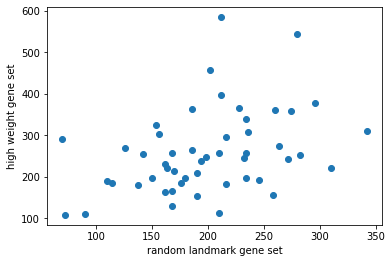



t-test p = 0.00048527543726957707


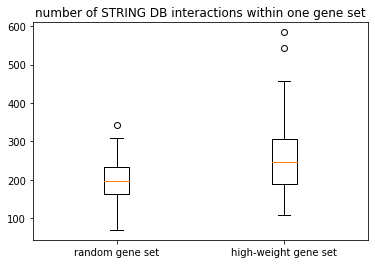

In [ ]:
%matplotlib inline
from scipy import stats

# compare number of interactions
rdata = random_gene_interaction.node_id.value_counts()
hdata = total_interactions.node_id.value_counts()

plt.close()
plt.scatter([rdata[i] for i in range(50)], [hdata[i] for i in range(50)])
plt.xlabel("random landmark gene set")
plt.ylabel("high weight gene set")
plt.show()

# perform t-test
t, p = stats.ttest_ind(rdata, hdata)
print('\n\nt-test p =', p)

plt.close()
data = [rdata, hdata]
fig, ax = plt.subplots()
ax.set_title('number of STRING DB interactions within one gene set')
ax.set_xticklabels(['random gene set','high-weight gene set'])
ax.boxplot(data)

plt.show()



t-test p = 0.9861972641297174


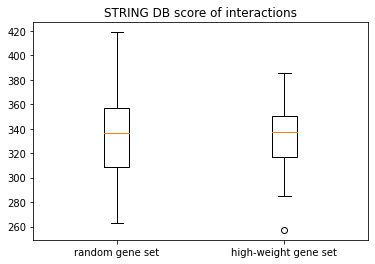

In [ ]:
%matplotlib inline
# compare combined_score of interactions
#rdata = random_gene_interaction.combined_score   # all combined_score
#hdata = total_interactions.combined_score  # all combined_score

rdata = [random_gene_interaction.loc[random_gene_interaction.node_id == i].combined_score.mean() for i in range(50)]   # average combined_score for each node
hdata = [total_interactions.loc[total_interactions.node_id == i].combined_score.mean() for i in range(50)]  # average combined_score for each node

# perform t-test
t, p = stats.ttest_ind(rdata, hdata)
print('\n\nt-test p =', p)

## plot the training and validation curve
plt.close()

data = [rdata, hdata]
fig, ax = plt.subplots()
ax.set_title('STRING DB score of interactions')
ax.set_xticklabels(['random gene set','high-weight gene set'])
ax.boxplot(data)

plt.show()

### 3.2 GO term analysis on gene sets with g:profile

see documentation here: https://pypi.org/project/gprofiler-official

In [ ]:
!pip install gprofiler-official

In [ ]:
from gprofiler import GProfiler
#HWgene = pd.read_csv(f'{work_dir}/trained_model/onelayer_encoder_A549landmark_gene_epoch1000_high_weight_genes.txt',sep='\t')
gp = GProfiler(return_dataframe=True)
terms = []
for i in HWgene['node_id'].unique():
    node_term = gp.profile(organism='hsapiens',query=HWgene.loc[HWgene['node_id']==i]['pr_gene_symbol'].tolist())
    node_term.loc[:,'node_id'] = i
    terms.append(node_term)
HWterms = pd.concat(terms)
HWterms.shape

(1937, 15)

In [ ]:
from gprofiler import GProfiler

gp = GProfiler(return_dataframe=True)
terms = []
for i in random_genes['node_id'].unique():
    node_term = gp.profile(organism='hsapiens',query=random_genes.loc[random_genes['node_id']==i]['pr_gene_symbol'].tolist())
    node_term.loc[:,'node_id'] = i
    terms.append(node_term)
Rterms = pd.concat(terms)
Rterms.shape

(1331, 15)

# Appendix: automatic tools

trainings with different hyper parameters

ADAGE Network Architecture:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Adage_linear_decoder(
  (encoder): Sequential(
    (0): Linear(in_features=978, out_features=50, bias=True)
    (1): ReLU(inplace=True)
  )
  (decoder): Linear(in_features=50, out_features=978, bias=True)
)

training start at Wed Apr 14 01:15:18 2021  __________________________________________________
__________________________________________________ 
Finished Training at Wed Apr 14 01:15:35 2021 
total training time: 17.28 s
train_data r_squre: 0.5177633970978205 
 valid_data r_squre: 0.4264618542563635
ADAGE Network Architecture:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Adage_linear_decoder(
  (encoder): Sequential(
    (0): Linear(in_features=978, out_features=792, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=792, out_features=606, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=606, out_features=420, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=420, out_features=234, b

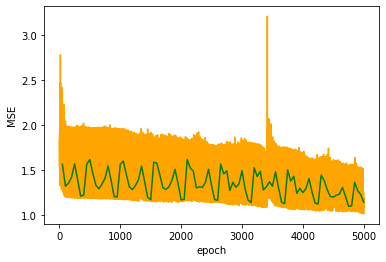

In [ ]:
##### auto train with different hyper-parameters
import sklearn.metrics
from sklearn.metrics import r2_score

iteration_n = 5000
node_n=50
for i in range(3):
    for layers in [1, 5, 10]:

        model_name = f"{layers}layers_{node_n}nodes_landmarkgene_DDRi_r_withnoise"
        valid_point_epoch = 50
        model_save_epoch = 500
        learning_rate = 0.002

        ## instantiate the model
        DA = Adage_linear_decoder(train_data.shape[1], node_number=node_n, encoder_layers = layers)
        print("{}\nADAGE Network Architecture:\n{}\n{}\n".format("="*31, "~"*31, DA))

        ## train the model
        DA = train_model(DA, model_name, valid_point_epoch = valid_point_epoch, model_save_epoch = model_save_epoch, iteration_n = iteration_n, print_train = False)
        # calculate r2 to show relation between orininal gene expression and reconstruct gene expression
        data1=torch.tensor(train_data).float()
        data2=DA(data1).detach().numpy()
        data1=data1.detach().numpy()
        data3=torch.tensor(valid_data).float()
        data4=DA(data3).detach().numpy()
        data3=data3.detach().numpy()

        print("train_data r_squre:",r2_score(data1, data2), "\n","valid_data r_squre:", r2_score(data3,data4))




## Auto run for evaluating STRING interactions within gene sets:

1. function to compare STRING interactions with random gene interactions

In [ ]:
from scipy import stats
def STRINGdb_compare(HWgene, random_genes, work_dir, model_name_epoch):
    HWgene['STRING_ID'] = [STRINGID_dict[s] for s in HWgene['pr_gene_symbol'].to_list()]
    total_interactions = extract_STRINGinteractions(HWgene,  save=True, save_path= f'{work_dir}/trained_model/{model_name_epoch}_HWgene_stringdb_records.txt')
    random_gene_interaction = extract_STRINGinteractions(random_genes,save=True,save_path=f'{work_dir}/trained_model/{model_name_epoch}_random_landmark_stringdb_records.txt')

    ## plot the number of interactions 
    rdata = random_gene_interaction.node_id.value_counts()
    hdata = total_interactions.node_id.value_counts()
    # perform t-test
    t, p = stats.ttest_ind(rdata, hdata)
    #print('\n\nt-test p =', p)

    plt.close()
    data = [rdata, hdata]
    fig, ax = plt.subplots()
    ax.set_title(f'number of STRING DB interactions within one gene set\nt-test p ={p}')
    ax.set_xticklabels(['random gene set','high-weight gene set'])
    ax.boxplot(data)
    plt.savefig(f'{work_dir}/trained_model/{model_name_epoch}_stringdb_interaction_number.pdf')

    ## plot combined_score of interactions

    rdata2 = [random_gene_interaction.loc[random_gene_interaction.node_id == i].combined_score.mean() for i in random_gene_interaction.node_id.unique()]   # average combined_score for each node
    hdata2 = [total_interactions.loc[total_interactions.node_id == i].combined_score.mean() for i in total_interactions.node_id.unique()]  # average combined_score for each node
    # perform t-test
    t2, p2 = stats.ttest_ind(rdata2, hdata2)
    
    plt.close()
    data2 = [rdata2, hdata2]
    fig, ax = plt.subplots()
    ax.set_title(f'STRING DB score of interactions\nt-test p ={p2}')
    ax.set_xticklabels(['random gene set','high-weight gene set'])
    ax.boxplot(data2)
    plt.savefig(f'{work_dir}/trained_model/{model_name_epoch}_stringdb_interaction_score.pdf')


In [ ]:
## load stringdb ID dictionary
with open(f'{work_dir}/landmark_gene_STRING_ID.txt') as f:
    for line in f:
        (key, val) = line[:-1].split('\t')
        STRINGID_dict[key] = val
## load stringdb interactions
stringdb = pd.read_csv(f'{work_dir}/9606.protein.links.v11.0.txt', sep=' ') 
stringdb.head()

,protein1,protein2,combined_score
0,9606.ENSP00000000233,9606.ENSP00000272298,490
1,9606.ENSP00000000233,9606.ENSP00000253401,198
2,9606.ENSP00000000233,9606.ENSP00000401445,159
3,9606.ENSP00000000233,9606.ENSP00000418915,606
4,9606.ENSP00000000233,9606.ENSP00000327801,167


2. loop to run different comparisons

=== 1layers_50nodes_landmarkgene_DDRi_r_epoch5000


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

=== 5layers_50nodes_landmarkgene_DDRi_r_epoch5000


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

=== Warning === gene set #10: 1 genes contain 0 links
=== Warning === gene set #13: 1 genes contain 0 links
=== Warning === gene set #22: 1 genes contain 0 links
=== Warning === gene set #26: 2 genes contain 0 links
=== Warning === gene set #28: 1 genes contain 0 links
=== Warning === gene set #31: 1 genes contain 0 links
=== Warning === gene set #46: 1 genes contain 0 links
=== Warning === gene set #10: 1 genes contain 0 links
=== Warning === gene set #13: 1 genes contain 0 links
=== Warning === gene set #17: 3 genes contain 0 links
=== Warning === gene set #22: 1 genes contain 0 links
=== Warning === gene set #26: 2 genes contain 0 links
=== Warning === gene set #28: 1 genes contain 0 links
=== Warning === gene set #31: 1 genes contain 0 links
=== Warning === gene set #46: 1 genes contain 0 links
=== Warning === gene set #47: 3 genes contain 0 links


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


=== 10layers_50nodes_landmarkgene_DDRi_r_epoch5000
node 2 0 gene.
node 23 0 gene.
node 29 0 gene.
node 36 0 gene.


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

node 39 0 gene.
node 40 0 gene.
node 41 0 gene.
=== Warning === gene set #21: 7 genes contain 0 links
=== Warning === gene set #22: 1 genes contain 0 links
=== Warning === gene set #21: 7 genes contain 0 links
=== Warning === gene set #22: 1 genes contain 0 links
=== 1layers_100nodes_landmarkgene_DDRi_r_epoch5000


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

=== 5layers_100nodes_landmarkgene_DDRi_r_epoch5000


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

=== Warning === gene set #8: 1 genes contain 0 links
=== Warning === gene set #17: 1 genes contain 0 links
=== Warning === gene set #25: 1 genes contain 0 links
=== Warning === gene set #45: 1 genes contain 0 links
=== Warning === gene set #47: 1 genes contain 0 links
=== Warning === gene set #48: 1 genes contain 0 links
=== Warning === gene set #56: 1 genes contain 0 links
=== Warning === gene set #59: 2 genes contain 0 links
=== Warning === gene set #76: 1 genes contain 0 links
=== Warning === gene set #77: 1 genes contain 0 links
=== Warning === gene set #87: 1 genes contain 0 links
=== Warning === gene set #94: 2 genes contain 0 links
=== Warning === gene set #3: 3 genes contain 0 links
=== Warning === gene set #8: 1 genes contain 0 links
=== Warning === gene set #17: 1 genes contain 0 links
=== Warning === gene set #25: 1 genes contain 0 links
=== Warning === gene set #45: 1 genes contain 0 links
=== Warning === gene set #47: 1 genes contain 0 links
=== Warning === gene set #48: 1

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

=== 10layers_100nodes_landmarkgene_DDRi_r_epoch5000
node 59 0 gene.
node 67 0 gene.
node 74 0 gene.
node 84 0 gene.
node 95 0 gene.
node 96 0 gene.
=== Warning === gene set #2: 1 genes contain 0 links
=== Warning === gene set #3: 1 genes contain 0 links
=== Warning === gene set #11: 2 genes contain 0 links
=== Warning === gene set #21: 2 genes contain 0 links
=== Warning === gene set #32: 1 genes contain 0 links
=== Warning === gene set #33: 2 genes contain 0 links
=== Warning === gene set #51: 1 genes contain 0 links
=== Warning === gene set #54: 2 genes contain 0 links
=== Warning === gene set #61: 1 genes contain 0 links
=== Warning === gene set #76: 1 genes contain 0 links
=== Warning === gene set #90: 2 genes contain 0 links
=== Warning === gene set #92: 1 genes contain 0 links
=== Warning === gene set #97: 2 genes contain 0 links
=== Warning === gene set #2: 1 genes contain 0 links
=== Warning === gene set #3: 1 genes contain 0 links
=== Warning === gene set #13: 2 genes contain 

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


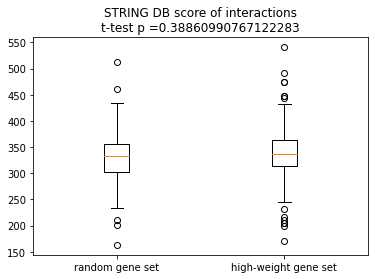

In [ ]:
## evaluate interactions in each gene set
# load trained model
epoch_n = 5000

for node_n in [50,100]:
    for layers in [1, 5, 10]:

        model_name_epoch=f"{layers}layers_{node_n}nodes_landmarkgene_DDRi_r_epoch{epoch_n}"
        print('===',model_name_epoch)
        DA = Adage_linear_decoder(train_data.shape[1], node_number=node_n, encoder_layers = layers)
        DA.load_state_dict(torch.load(f'{work_dir}/trained_model/{model_name_epoch}'))

        # extract high weight gene
        HWgene = extract_decoder_high_weight_gene(DA)
        HWgene['STRING_ID'] = [STRINGID_dict[s] for s in HWgene['pr_gene_symbol'].to_list()]

        # matplotlib histogram
        t_weight = DA.decoder.weight.T
        node_num = t_weight.shape[0]

        w_mean = t_weight.mean(dim=1).reshape(t_weight.shape[0],1)
        w_std = t_weight.std(dim=1).reshape(t_weight.shape[0],1)

        plt.figure(figsize=(32,node_num))
        for i in range(node_num):
            hwgene_num = len(HWgene.loc[HWgene.node_id == i].index)

            ax = plt.subplot(node_num/5, 5, i + 1)
            ax.hist(t_weight[i].tolist(), color = '#56B4E9', edgecolor = 'white',bins = int(80))
            ax.vlines([(w_mean-2*w_std)[i].item(),(w_mean+2*w_std)[i].item()], ymin=0, ymax=50, colors= 'red')
            ax.vlines(w_mean[i].item(), ymin=0, ymax=50, colors= 'red',linestyles='dashed')
            # Add labels
            ax.set_title(f'weight distribution from node #{i}\n number of high-weight genes: {hwgene_num}')
            ax.set_xlabel('gene weight')
            ax.set_ylabel('genes')

        plt.tight_layout()
        plt.savefig(f"{work_dir}/trained_model/{layers}layers_{node_n}nodes_landmarkgene_DDRi_r_epoch{epoch_n}_weight_distribution.pdf")
        plt.close()



        # generate random gene set
        import random
        L1000gene = landmark_gene_list['pr_gene_symbol'].to_list()
        random_gene_list = []
        for i in HWgene['node_id'].unique():
            gene_number = HWgene.node_id.value_counts()[i]
            random_gene = random.sample(L1000gene, gene_number)
            random_gene_stringID = [STRINGID_dict[s] for s in random_gene]
            random_df = pd.DataFrame([(x[0],x[1],i) for x in zip(random_gene,random_gene_stringID)], columns=['pr_gene_symbol','STRING_ID','node_id'])
            random_gene_list.append(random_df)
        random_genes = pd.concat(random_gene_list)
        random_genes.to_csv(f'{work_dir}/trained_model/{model_name_epoch}_random_landmark_genes.txt',sep='\t',index=False)
        random_genes.head()

        # compare the interactions
        STRINGdb_compare(HWgene, random_genes, work_dir, model_name_epoch)
 
